# User Retention by Cohort

This template helps visualize user retention as the percentage of users in an acquisition cohort who are still using the product after several elapsed time periods. Retention can be visualized in two different ways:

1. __Annotated Heatmap__: An annotated heatmap of retention by cohort is useful to visualize and compare rates across cohorts and time periods.

2. __Line Plot__: A line plot of retention grouped by cohort is useful to visualize the dropoff in users over time periods.

In [1]:
# Load packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

## 1. Load your data

Each row in the data aggregates the number of users by cohort and segment who were active in a time period. ([user-activity.csv](https://static.observableusercontent.com/files/412f6661ef5417077a9224bb75826ee889a1f43e7f60077bb2abfc7332e0808e4f1519afc3a8f6f263d57c635e9229d11acd3197925875d8a37a342246d72397?response-content-disposition=attachment%3Bfilename*%3DUTF-8%27%27cohorts.csv))


In [2]:
# Upload your data as CSV and load as a data frame
df = pd.read_csv('data/user-activity.csv', parse_dates=["cohort_date", "period_date"])
df.head()

,cohort_date,period_date,segment,nb_users
0,2020-09-28,2020-09-28,home,212680
1,2020-09-28,2020-09-28,referral,337599
2,2020-09-28,2020-09-28,search,233801
3,2020-09-28,2020-10-05,home,77290
4,2020-09-28,2020-10-05,referral,126615


## 2. Compute Retention

The retention rate is computed as the percentage of users in a cohort (or cohort-segment) who stayed active over time.

In [3]:
# Compute Retention
def compute_retention(df):
    df_all = (
      df
        .groupby(['cohort_date', 'period_date'])
        .agg('sum')
        .reset_index()
    )
    df_all['period_index'] = (df_all['period_date'] - df_all['cohort_date']) / np.timedelta64(1, 'W')
    df_all['nb_users_total'] = df_all.groupby(['cohort_date'])['nb_users'].transform(max)
    df_all['pct_users'] = df_all['nb_users'] / df_all['nb_users_total']
    df_all.drop(columns = ['nb_users_total'], inplace=True)
    df_all = df_all[['cohort_date', 'period_date', 'period_index', 'nb_users', 'pct_users']]
    return df_all

df_retention = compute_retention(df)
df_retention.head()

,cohort_date,period_date,period_index,nb_users,pct_users
0,2020-09-28,2020-09-28,0.0,784080,1.000000
1,2020-09-28,2020-10-05,1.0,291347,0.371578
2,2020-09-28,2020-10-12,2.0,144925,0.184834
3,2020-09-28,2020-10-19,3.0,105378,0.134397
4,2020-09-28,2020-10-26,4.0,93739,0.119553


## 3. Visualize retention as heatmap

Each row in the heatmap represents a cohort and visualizes the percentage of users retained over time.

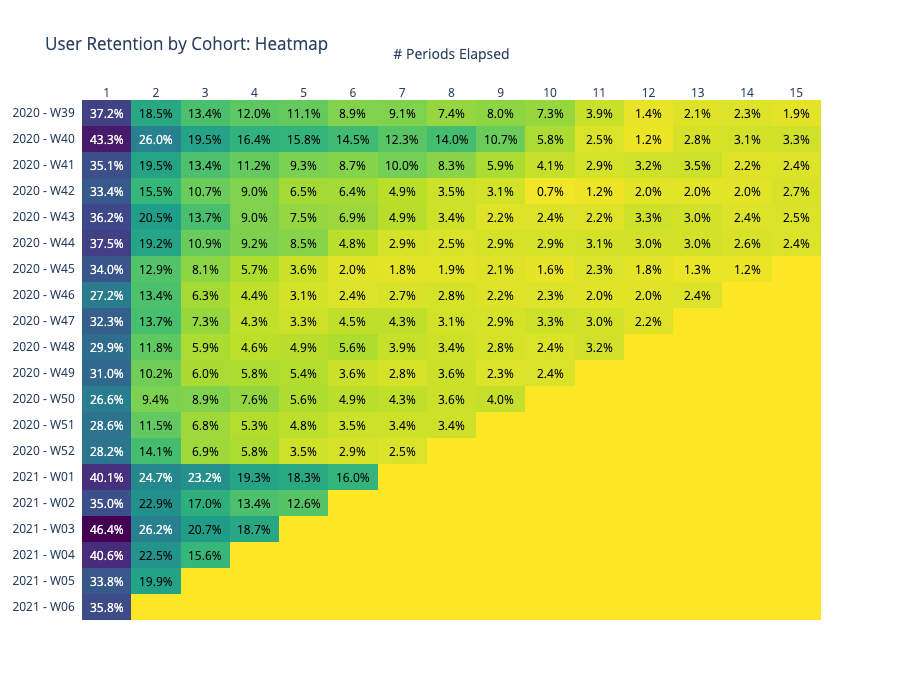

In [6]:
# Plot cohort retention heatmap
def plot_cohorts_heatmap(df, nb_periods=15):
  df = df.query('period_index > 0 & period_index <= @nb_periods')
  df_wide = (df
    .pivot(index="cohort_date", columns='period_index', values='pct_users')
    .sort_values(by=['cohort_date'], ascending=False)
    .fillna(0)
  )
  fig = ff.create_annotated_heatmap(
      z = df_wide.values, 
      annotation_text = df_wide.applymap(lambda x: '{:.1%}'.format(x) if x > 0 else '').values.tolist(),
      y = df_wide.index.strftime('%Y - W%W').values.tolist(),
      x = df_wide.columns.tolist(),
      colorscale='viridis_r',
  )
  fig.update_layout(
      width=900, 
      height=700, 
      xaxis={"title": "# Periods Elapsed"},
      title="User Retention by Cohort: Heatmap")
  return fig

fig = plot_cohorts_heatmap(df_retention)
fig.show(config={"displayModeBar": False})

## Visualize retention as line plot

Each line represents a cohort and visualizes the dropoff in number of users over time.

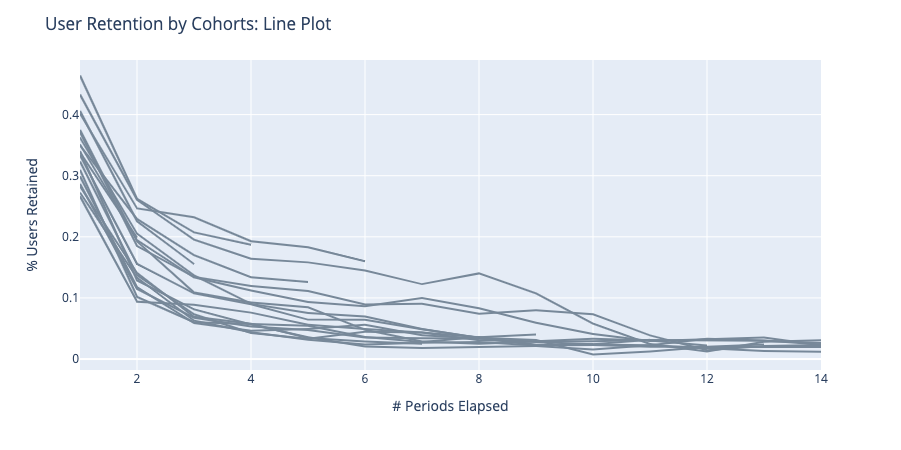

In [5]:
# Plot cohort retention lines
def plot_cohort_lines(df, nb_periods=15):
  df['cohort_date'] = df['cohort_date'].astype(str)
  fig = px.line(
    df.query('period_index > 0 & period_index < @nb_periods'), 
    x='period_index', 
    y='pct_users', 
    line_group='cohort_date', 
    color_discrete_sequence=["lightslategray"]
  )
  fig.update_layout(
    xaxis = {"title": "# Periods Elapsed"},
    yaxis = {"title": "% Users Retained"},
    title="User Retention by Cohorts: Line Plot"
  )
  return fig


fig_lines = plot_cohort_lines(df_retention)
fig_lines.show(config = {"displayModeBar": False})